Let's start our Practical Session 2 : 


# Task 1

## Our first streaming using rate source


### Initialization SparkSession

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
import logging
import numpy
from pyspark.sql.functions import *

### Let’s first import the required libraries.

*   Pyspark functions 
*   Pyspark Types



In [2]:
spark = SparkSession.builder \
    .appName("Read lines over a network stream") \
    .master("local[*]").getOrCreate()

21/11/04 22:46:26 WARN Utils: Your hostname, ahmed-G3-3579 resolves to a loopback address: 127.0.1.1; using 192.168.1.9 instead (on interface wlo1)
21/11/04 22:46:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/04 22:46:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Create streaming DataFrame


Let’s create our first Spark Streaming DataFrame using "rate" format. Here we have specified the format as rate and specified rowsPerSecond = 1 to generate 1 row for each micro-batch and load the data into initDF streaming DataFrame. 

In [4]:
df = spark.readStream.format("rate") \
    .option('rowsPerSecond',1)\
    .load()

### Check if DataFrame is streaming or Not.


In [5]:
df.isStreaming

True

### Transformation

Perform transformation on initDF to generate another column result by just adding 1 to column value :


### Output

In [6]:
df = df.withColumn('plus', col('value') + lit(1))

### Our Second streaming using rate source

### Create Streaming DataFrame

### Create Streaming DataFrame using socket source. Also, check if DataFrame isStreaming.


In [7]:
from pyspark.sql.functions import *
lines = (spark
         .readStream.format("socket")
         .option("host", "localhost")
         .option("port", 12345)
         .load())

21/11/02 17:42:40 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


In [8]:
lines.isStreaming

True

### Transformation: Word Count


Here we count words from a stream of data coming from this socket. Also, we check the schema of our streaming DataFrame.


In [7]:
words = lines.select(explode(split(lines.value, " ")).alias("word"))
wordCounts = words.groupBy("word").count()

In [ ]:
streamingQuery = (wordCounts.writeStream
                  .format("console")
                  .outputMode("complete")
                  .start())
streamingQuery.awaitTermination()

21/11/02 17:26:08 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-dba64266-3267-4c78-8c77-0dbfcef5d84f. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
+----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+-----+-----+
| word|count|
+-----+-----+
|hello|    1|
+-----+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+-----+-----+
| word|count|
+-----+-----+
|hello|    1|
| test|    2|
+-----+-----+



-------------------------------------------
Batch: 3
-------------------------------------------
+---------+-----+
|     word|count|
+---------+-----+
|      one|    1|
|    hello|    1|
|      any|    1|
|listining|    1|
|     test|    2|
+---------+-----+



#### to check nc -lk 9999


### Input Sources — File

Schema Our data contains the fields Date,Open,High,Low,Close,Adj Close,Volume and we will extract Name from the filename using a custom function.
Here we define the schema and write a custom function to extract the stock ticker symbol.

In [3]:
from pyspark.sql.types import (StructType, StructField,
                               StringType, IntegerType,TimestampType,FloatType)


recordSchema = StructType([StructField('Date', TimestampType(), True),
                           StructField('Open', FloatType(), True),
                           StructField('High', FloatType(), True),
                           StructField('Low', FloatType(), True),
                           StructField('Close', FloatType(), True),
                           StructField('Volume', FloatType(), True),
                           StructField('Name', StringType(), True)])

df = spark.readStream.format("csv") \
    .option('header', 'true') \
    .schema(recordSchema) \
    .load("/home/ahmed/spark/")

#### Create Streaming DataFrame


Create a streaming DataFrame to read csv data from a specified directory "data/stream" and apply the above schema . We also specify the param maxFilesPerTrigger = 2 , which means our application will process a maximum of 2 CSV files in each batch. At the end, we create another column called Name using the function getFileName. That column contains stock ticker symbols like GOOGL, AMZN, AAPL etc.

In [5]:
tdf = df\
.groupBy(col("Name"), year(col("Date")))\
.agg(max("High"))

#### Transformation

Group the data based on stock Name, Year and find the maximum value of the HIGH column.

In [6]:
tdf = df\
.groupBy(col("Name"), year(col("Date")))\
.agg(max("High"))

Can you build same transformation by Sql? 

In [7]:
df.createOrReplaceTempView("temp")
sdf = spark.sql("""SELECT year(Date) AS Year, Name, max(High) 
          FROM temp 
          GROUP BY Name, Year""")

#### Output
Print the contents of streaming DatFrame to console using update mode.




Work with any dataset from data file 

In [8]:
w = tdf.writeStream\
.outputMode("update")\
.format("console")

In [ ]:
query3 = w.start()
query3.awaitTermination()

21/11/04 22:41:35 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-b7c29772-4cdc-4d9e-8390-2b317cf6aa45. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+----------+---------+
|Name|year(Date)|max(High)|
+----+----------+---------+
|AABA|      2015|    50.78|
|AABA|      2008|    30.25|
|AABA|      2006|    43.66|
|AABA|      2014|    52.62|
|AABA|      2007|    34.08|
|AABA|      2011|    18.84|
|AABA|      2013|    41.05|
|AABA|      2010|    19.12|
|AABA|      2012|    19.97|
|AABA|      2017|    73.25|
|AABA|      2016|    44.92|
|AABA|      2009|    18.02|
+----+----------+---------+



-------------------------------------------
Batch: 1
-------------------------------------------
+----+----------+---------+
|Name|year(Date)|max(High)|
+----+----------+---------+
| JNJ|      2015|    106.5|
| JNJ|      2017|   144.35|
| JNJ|      2007|    68.75|
| JNJ|      2012|    72.74|
| JNJ|      2010|     66.2|
| JNJ|      2006|    69.41|
| JNJ|      2013|    95.99|
| JNJ|      2009|    65.41|
| JNJ|      2008|    72.76|
| JNJ|      2011|    68.05|
| JNJ|      2014|   109.49|
| JNJ|      2016|   126.07|
+----+----------+---------+



# Task 2

### Some aggregations transformation
Select "Name","Date", "Open", "High", "Low" and group by Name and Date and get the avg and use WithColumn to get current_timestamp 


In [5]:
agdf = df.select("Name", "Date", "Open", "High", "Low")\
.groupBy(col("Name"), year(col("Date")))\
.agg(avg("High"))\
.withColumn("TimestampCol", current_timestamp())

### Checkpoints

In [7]:
w2 = agdf.writeStream\
.outputMode("complete")\
.option("checkpointLocation", "chkpoint")\
.format("console")

In [ ]:
query4 = w2.start()
query4.awaitTermination()

-------------------------------------------
Batch: 0
-------------------------------------------
+----+----------+------------------+--------------------+
|Name|year(Date)|         avg(High)|        TimestampCol|
+----+----------+------------------+--------------------+
| JNJ|      2015|100.40091278439476|2021-11-04 22:44:...|
| JNJ|      2017|  130.399362115746|2021-11-04 22:44:...|
| JNJ|      2007| 64.36338642013975|2021-11-04 22:44:...|
| JNJ|      2012| 67.24223986816406|2021-11-04 22:44:...|
| JNJ|      2010| 62.51027759673104|2021-11-04 22:44:...|
|AABA|      2015| 39.45888887132917|2021-11-04 22:44:...|
|AABA|      2008| 21.59841895951584|2021-11-04 22:44:...|
|AABA|      2006|30.400278904523507|2021-11-04 22:44:...|
|AABA|      2014|39.924484146965874|2021-11-04 22:44:...|
|AABA|      2007|27.940836651866654|2021-11-04 22:44:...|
|AABA|      2011|15.831190453635323|2021-11-04 22:44:...|
| JNJ|      2006| 62.52820717860978|2021-11-04 22:44:...|
| JNJ|      2013| 86.191031501406

-------------------------------------------
Batch: 1
-------------------------------------------
+----+----------+------------------+--------------------+
|Name|year(Date)|         avg(High)|        TimestampCol|
+----+----------+------------------+--------------------+
| JNJ|      2015|100.40091278439476|2021-11-04 22:46:...|
| JNJ|      2017|  130.399362115746|2021-11-04 22:46:...|
| JNJ|      2007| 64.36338642013975|2021-11-04 22:46:...|
| JNJ|      2012| 67.24223986816406|2021-11-04 22:46:...|
| JNJ|      2010| 62.51027759673104|2021-11-04 22:46:...|
| MMM|      2009| 64.61027770572238|2021-11-04 22:46:...|
|AABA|      2015| 39.45888887132917|2021-11-04 22:46:...|
| MMM|      2015|157.40460289849176|2021-11-04 22:46:...|
|AABA|      2008| 21.59841895951584|2021-11-04 22:46:...|
|AABA|      2006|30.400278904523507|2021-11-04 22:46:...|
|AABA|      2014|39.924484146965874|2021-11-04 22:46:...|
| MMM|      2007| 84.65342645531156|2021-11-04 22:46:...|
|AABA|      2007|27.9408366518666

# Task 3

### One-time micro-batch
With a once trigger, our query will execute a single micro-batch. It will process all available data and then stop the application. This trigger is useful when you would like to spin-up a cluster periodically, 
Execute our streaming application with the once trigger.

In [6]:
w3 = agdf.writeStream\
.outputMode("complete")\
.trigger(once=True)\
.format("console")

In [7]:
query5 = w3.start()
query5.awaitTermination()

21/11/04 22:47:56 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-80ff5272-b248-4ed5-b4f4-be55c159ddaa. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+----------+------------------+--------------------+
|Name|year(Date)|         avg(High)|        TimestampCol|
+----+----------+------------------+--------------------+
| JNJ|      2015|100.40091278439476|2021-11-04 22:47:...|
| JNJ|      2017|  130.399362115746|2021-11-04 22:47:...|
| JNJ|      2007| 64.36338642013975|2021-11-04 22:47:...|
| JNJ|      2012| 67.24223986816406|2021-11-04 22:47:...|
| JNJ|      2010| 62.51027759673104|2021-11-04 22:47:...|
| MMM|      2009| 64.61027770572238|2021-11-04 22:47:...|
|AABA|      2015| 39.45888887132917|2021-11-04 22:47:...|
| MMM|      2015|157.40460289849176|2021-11-04 22:47:...|
|AABA|      2008| 21.59841895951584|2021-11-04 22:47:...|
|AABA|      2006|30.400278904523507|2021-11-04 22:47:...|
|AABA|      2014|39.924484146965874|2021-11-04 22:47:...|
| MMM|      2007| 84.65342645531156|2021-11-04 22:47:...|
|AABA|      2007|27.9408366518666

### Users can create GraphFrames from vertex and edge DataFrames.

* Vertex DataFrame: A vertex DataFrame should contain a special column named “id” which specifies unique IDs for each vertex in the graph.
* Edge DataFrame: An edge DataFrame should contain two special columns: “src” (source vertex ID of edge) and “dst” (destination vertex ID of edge).

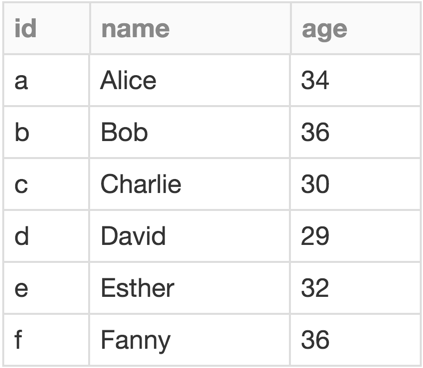

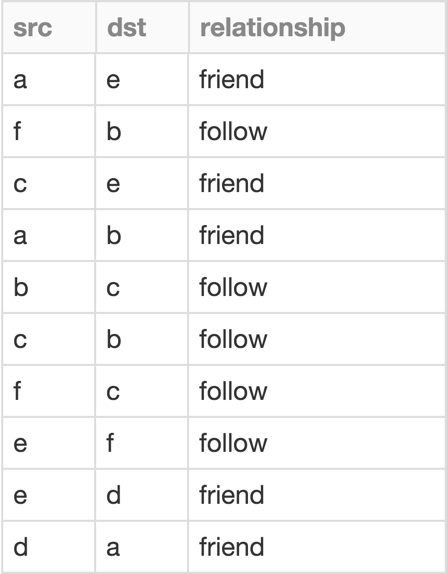

In [8]:
v = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36)
], ["id", "name", "age"])



e = spark.createDataFrame([
  ("a", "e", "friend"),
  ("f", "b", "follow"),
  ("c", "e", "friend"),
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend")
], ["src", "dst", "relationship"])

### Create a GraphFrame from vertex and edge DataFrames

In [9]:
sc = spark.sparkContext
sc.addPyFile('/opt/spark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar')

### Take a look at the DataFrames

Get vertices, edges, and check the number of edges of each vertex

In [10]:
from graphframes import *

In [11]:
g = GraphFrame(v, e)

In [12]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+



In [13]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  e|      friend|
|  f|  b|      follow|
|  c|  e|      friend|
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
+---+---+------------+



In [14]:
g.degrees.show()

+---+------+
| id|degree|
+---+------+
|  f|     3|
|  e|     4|
|  d|     2|
|  c|     4|
|  b|     4|
|  a|     3|
+---+------+



In [15]:
g.inDegrees.show()
g.outDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  f|       1|
|  e|       2|
|  d|       1|
|  c|       2|
|  b|       3|
|  a|       1|
+---+--------+

+---+---------+
| id|outDegree|
+---+---------+
|  f|        2|
|  e|        2|
|  d|        1|
|  c|        2|
|  b|        1|
|  a|        2|
+---+---------+



In [32]:
import networkx as nx
import matplotlib.pyplot as plt

def PlotGraph(edge_list):
    Gplot=nx.MultiDiGraph()
    for row in edge_list.select('src','dst').take(1000):
        Gplot.add_edge(row['src'],row['dst'])

    pos=nx.circular_layout(Gplot)
    plt.figure(figsize=(40,10))
    plt.subplot(121)
    nx.draw_networkx(Gplot,pos,node_size=1000,edgelist=[],font_size=20,linewidths=15)
    nx.draw_networkx_edges(Gplot, pos, connectionstyle='arc3,rad=0.2',alpha=0.8,arrowstyle='->,head_length=0.6, head_width=0.15',width=2,arrowsize=70)

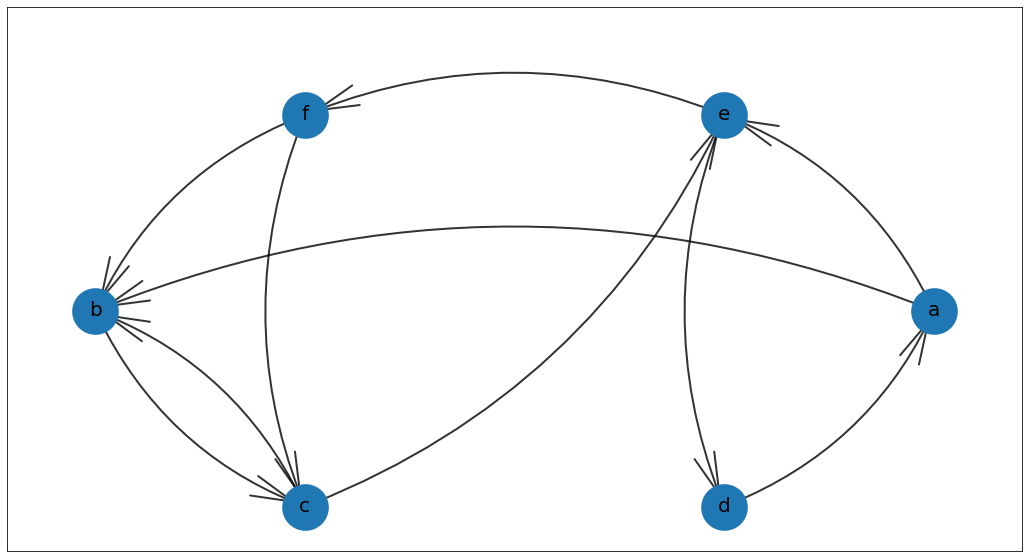

In [33]:
PlotGraph(g.edges)

## Create UDF Functions 
convert your graph by mapping a function over the edges DataFrame that deletes the row if src ≥ dst return "Delete" else "Keep"

In [17]:
from pyspark.sql.functions import udf

In [18]:
@udf(returnType=StringType())
def deleteOrKeep(src, dst):
    if src >= dst:
        return 'Delete'
    else : 
        return 'Keep'

In [19]:
e.withColumn('MappedCol', deleteOrKeep(e.src, e.dst))\
.filter('MappedCol == "Keep"').drop('MappedCol').show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  e|      friend|
|  c|  e|      friend|
|  a|  b|      friend|
|  b|  c|      follow|
|  e|  f|      follow|
+---+---+------------+



# Filtering and connected components

Check vertices when "age" greater than 30 and check edges "relationship" equal "friend" 

In [20]:
g.vertices.filter("age > 30").show()

+---+------+---+
| id|  name|age|
+---+------+---+
|  a| Alice| 34|
|  b|   Bob| 36|
|  e|Esther| 32|
|  f| Fanny| 36|
+---+------+---+



In [21]:
g.edges.filter("relationship = 'friend'").show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  e|      friend|
|  c|  e|      friend|
|  a|  b|      friend|
|  e|  d|      friend|
|  d|  a|      friend|
+---+---+------------+



In [22]:
g2 = g.filterVertices("age>30").filterEdges("relationship = 'friend'").dropIsolatedVertices()
g2.vertices.show()
g2.edges.show()

+---+------+---+
| id|  name|age|
+---+------+---+
|  e|Esther| 32|
|  b|   Bob| 36|
|  a| Alice| 34|
+---+------+---+



+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  e|      friend|
|  a|  b|      friend|
+---+---+------------+



GraphFrames requires you to set a directory where it can save checkpoints. Create such a folder in your working directory 

In [24]:
spark.sparkContext.setCheckpointDir("/home/ahmed/spark/check_points")

Then, the connected components can easily be computed with the connectedComponents-function.


In [25]:
g.connectedComponents().show()

+---+-------+---+------------+
| id|   name|age|   component|
+---+-------+---+------------+
|  a|  Alice| 34|412316860416|
|  b|    Bob| 36|412316860416|
|  c|Charlie| 30|412316860416|
|  d|  David| 29|412316860416|
|  e| Esther| 32|412316860416|
|  f|  Fanny| 36|412316860416|
+---+-------+---+------------+



## Motif finding


Search for pairs of vertices a,b connected by edge e and pairs of vertices b,c connected by edge e2. It will return a DataFrame of all such structures in the graph

In [26]:
motif = g.find("(v1)-[e]->(v2);(v2)-[e2]->(v3)")

In [27]:
motif.show()

+----------------+--------------+----------------+--------------+----------------+
|              v1|             e|              v2|            e2|              v3|
+----------------+--------------+----------------+--------------+----------------+
|[c, Charlie, 30]|[c, e, friend]| [e, Esther, 32]|[e, f, follow]|  [f, Fanny, 36]|
|  [a, Alice, 34]|[a, e, friend]| [e, Esther, 32]|[e, f, follow]|  [f, Fanny, 36]|
|  [f, Fanny, 36]|[f, c, follow]|[c, Charlie, 30]|[c, e, friend]| [e, Esther, 32]|
|    [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|[c, e, friend]| [e, Esther, 32]|
|  [d, David, 29]|[d, a, friend]|  [a, Alice, 34]|[a, e, friend]| [e, Esther, 32]|
|[c, Charlie, 30]|[c, e, friend]| [e, Esther, 32]|[e, d, friend]|  [d, David, 29]|
|  [a, Alice, 34]|[a, e, friend]| [e, Esther, 32]|[e, d, friend]|  [d, David, 29]|
| [e, Esther, 32]|[e, f, follow]|  [f, Fanny, 36]|[f, c, follow]|[c, Charlie, 30]|
|  [f, Fanny, 36]|[f, b, follow]|    [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|
|[c,

In [28]:
motif.filter("v1.id == 'a' and v2.id == 'b' and v3.id == 'c'").show()

+--------------+--------------+------------+--------------+----------------+
|            v1|             e|          v2|            e2|              v3|
+--------------+--------------+------------+--------------+----------------+
|[a, Alice, 34]|[a, b, friend]|[b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|
+--------------+--------------+------------+--------------+----------------+

